# SpikeGLX Processing

**Data Owners:** Rahim Hashim, Roberto Gulli, Stefano Fusi, Daniel Salzman<br>
**Notebook Owner:** Rahim Hashim

In [1]:
# This example imports functions from the DemoReadSGLXData module to read
# analog data and convert it to volts based on the metadata information.
# The metadata file must be present in the same directory as the binary file.
# Works with both imec and nidq analog channels.

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
from tkinter import Tk
from tkinter import filedialog
from readSGLX import readMeta, SampRate, makeMemMapRaw, GainCorrectIM, GainCorrectNI

def print_meta(meta, verbose=False):
  if verbose:
    for meta_key in meta.keys():
      print(meta_key, meta[meta_key])
  file_name = meta['fileName']
  n_channels = meta['nSavedChans']
  file_created_time = meta['fileCreateTime']
  file_length = meta['fileTimeSecs']
  print(f'File Name: {file_name}')
  print(f'  Number of Channels: {n_channels}')
  print(f'  File Created: {file_created_time}')
  print(f'  File Length: {file_length}')
  return n_channels

def get_spikeglx_path():
  # Get bin file from user
  root = Tk()         # create the Tkinter widget
  root.withdraw()     # hide the Tkinter root window
  # Windows specific; forces the window to appear in front
  root.attributes("-topmost", True)
  binFullPath = Path(filedialog.askopenfilename(title="Select binary file"))
  root.destroy()   
  
  return binFullPath

def load_spikeglx(binFullPath):
  # Read <file>.meta
  meta = readMeta(binFullPath)

  print(meta)

  # Find Number of Channels
  n_channels = print_meta(meta)

  # Initialize Channel Dictionary
  chan_dict = defaultdict(list)

  for chan in np.arange(int(n_channels)-1):
    print('Channel', chan)
    chanList = [chan]

    rawData = makeMemMapRaw(binFullPath, meta)
    # Assign channel raw data to dictionary
    chan_dict[chan] = rawData
  return meta, chan_dict

def plot_channels(meta, chan_dict, tStart, tEnd):

  # Calculate Sample Rate
  sRate = SampRate(meta)

  firstSamp = int(sRate*tStart)
  lastSamp = int(sRate*tEnd)

  # Plot all channels
  f, ax = plt.subplots(1)
  for chan in chan_dict.keys():
    rawData = chan_dict[chan]
    chanList = [chan]
    selectData = rawData[chanList, firstSamp:lastSamp+1]
    if meta['typeThis'] == 'imec':
        # apply gain correction and convert to uV
        convData = 1e6*GainCorrectIM(selectData, chanList, meta)
    else:
        # apply gain correction and convert to mV
        convData = 1e3*GainCorrectNI(selectData, chanList, meta)
    # Plot the first of the extracted channels
    tDat = np.arange(firstSamp, lastSamp+1)
    tDat = 1000*tDat/sRate      # plot time axis in msec
    print(f'  Max Val: {max(convData[0, :])}')
    print(f'  Min Val: {min(convData[0, :])}')
    ax.plot(tDat, convData[0, :], label=chan)
    print(convData[0, :])
    # Add labels to plot each with a different color
  plt.legend()    
  plt.show()


2023-08-25 10:25:05.210 python[51160:816119] +[CATransaction synchronize] called within transaction


  Max Val: 3341.064453125
  Min Val: -5.79833984375
[ 0.15258789 -0.45776367  0.         ... -1.22070312  0.76293945
 -1.22070312]
  Max Val: 3356.781005859375
  Min Val: -17.39501953125
[-1.22070312e+00 -4.11987305e+00  3.20434570e+00 ...  3.30871582e+03
  3.31817627e+03  3.31192017e+03]
  Max Val: 4999.847412109375
  Min Val: -20.751953125
[3.05175781e+00 3.96728516e+00 4.11987305e+00 ... 4.99084473e+03
 4.99145508e+03 4.99145508e+03]
  Max Val: 2290.0390625
  Min Val: 503.692626953125
[1196.44165039 1150.20751953 1199.95117188 ...  544.89135742  553.89404297
  545.95947266]


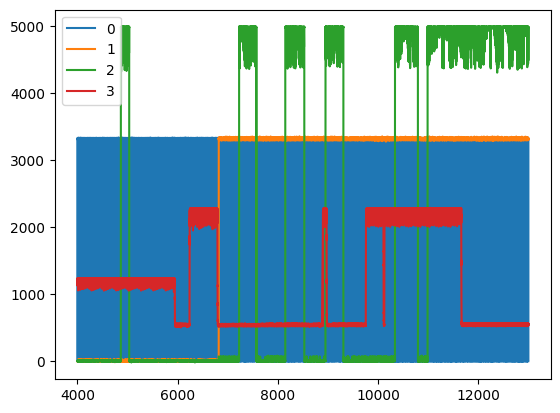

In [3]:
plot_channels(meta, chan_dict, tStart = 4, tEnd = 13)